# NMF-KNN: Image Annotation using Weighted Multi-view Non-negative Matrix Factorization

## Objective (What?)

Our goal is to apply NMF to real-world problems and explore its benefits. Particularly, we are interested in Image Annotation using NMF-KNN. We have referenced this (https://openaccess.thecvf.com/content_cvpr_2014/papers/Kalayeh_NMF-KNN_Image_Annotation_2014_CVPR_paper.pdf) research paper from CVPR 2014, which integrates NMF into a KNN pipeline, providing several advantages as discussed in the following sections.

## Authors (Who?)
- Sanidhya Kumar (202151138)
- Varun Vilvadrinath (202151195)
- Riya (202151132)

## Why use NMF in NMF-KNN pipeline?

Non-negative Matrix Factorization (NMF) is used in NMF-KNN for the following reasons:

1. **Dimensionality Reduction**: NMF reduces the dimensionality of the data while preserving meaningful features, making it easier for KNN to work effectively.
2. **Interpretability**: NMF provides a parts-based representation, which can make the features more interpretable.
3. **Improved Performance**: By reducing noise and focusing on the most important features, NMF can enhance the performance of KNN.
4. **Handling Sparsity**: NMF is well-suited for sparse data, which is common in many datasets.

These advantages make NMF a useful preprocessing step before applying KNN in various applications.

## Motivation

The motivation behind this project is to leverage the strengths of Non-negative Matrix Factorization (NMF) in solving real-world image annotation tasks. Image annotation plays a crucial role in various computer vision applications, yet it remains a challenging problem due to the high dimensionality and sparsity of image data. By integrating NMF with the KNN algorithm, we aim to overcome these challenges by reducing dimensionality, improving interpretability, and enhancing performance. The CVPR 2014 research paper provides a solid foundation for this approach, demonstrating how NMF can be effectively used in a KNN pipeline to achieve better results in image annotation. This motivates us to explore and apply this method in our project.

## How?

Here, we aim to explain each step in detail. We began by exploring NMF, followed by studying different NMF methods. We then applied it to a small project before finally incorporating it into the main project. Let's have a look.

## Exploring NMF and various methods of NMF

### Part 1: NMF-KNN (Iterative)

In [2]:
# Imports
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

In [3]:
# Step 1: Implement NMF (Iterative) from Scratch
def nmf_iter(V, rank, max_iter=500, tol=1e-4):
    """
    Perform Non-negative Matrix Factorization (NMF) on matrix V.
    
    Parameters:
    V (ndarray): The non-negative input matrix of shape (m, n).
    rank (int): The number of components (rank) for the factorization.
    max_iter (int): Maximum number of iterations.
    tol (float): Tolerance for the stopping condition.
    
    Returns:
    W (ndarray): Basis matrix of shape (m, rank).
    H (ndarray): Coefficient matrix of shape (rank, n).
    """
    m, n = V.shape

    # Initialize W and H with random values
    np.random.seed(42)
    W = np.random.rand(m, rank)
    H = np.random.rand(rank, n)

    for i in range(max_iter):
        # Update H using multiplicative update rule
        H_update = (W.T @ V) / (W.T @ W @ H + 1e-9)
        H *= H_update

        # Update W using multiplicative update rule
        W_update = (V @ H.T) / (W @ H @ H.T + 1e-9)
        W *= W_update

        # Compute reconstruction error
        V_approx = W @ H
        error = np.linalg.norm(V - V_approx, 'fro')

        if error < tol:
            print(f"Converged at iteration {i+1} with error {error:.4f}")
            break

    return W, H

Actual label: 0


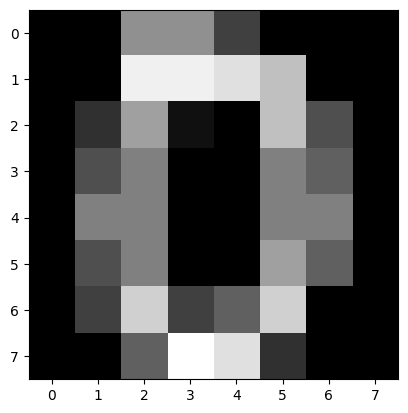

In [13]:
# Step 2: Load and Prepare the Data (Using the digits dataset from sklearn for demonstration)
digits = load_digits()
X = digits.data  # Flattened images (64 features per image, 8x8 pixels)
y = digits.target  # Labels (0-9 digits)

# Step 3: Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random image from training set
plt.imshow(X_train[1].reshape(8, 8), cmap='gray') 
print("Actual label:", y_train[1])

In [14]:
# Step 4: Apply Custom NMF to Reduce Dimensionality
rank = 20  # Number of components for NMF
W_train, H_train = nmf_iter(X_train.T, rank)  # Note: Transpose X_train for correct dimensions
H_test = np.linalg.lstsq(W_train, X_test.T, rcond=None)[0]  # Solve for H_test

In [15]:
# Step 5: Train the KNN Classifier on the Reduced Data
k = 3  # Number of neighbors
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(H_train.T, y_train)

KNeighborsClassifier(n_neighbors=3)

In [18]:
# Step 6: Predict and Evaluate the Model on Test Data
y_pred = knn.predict(H_test.T)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f} %")

Accuracy: 96.11 %


Predicted Labels for New Images: [6 9 3 7 2]


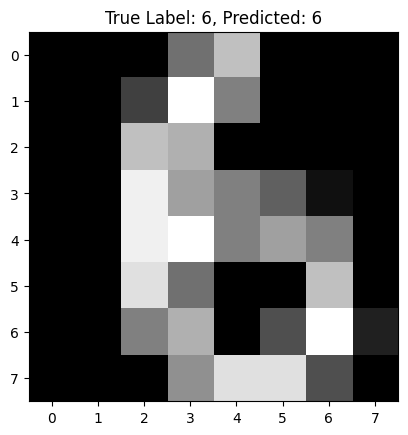

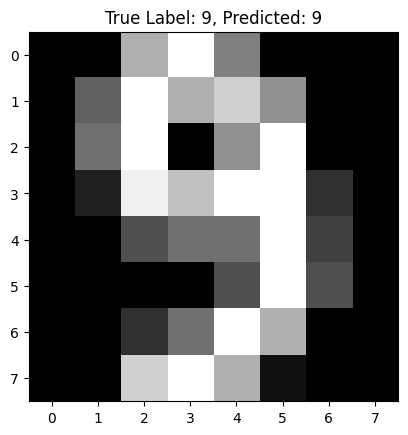

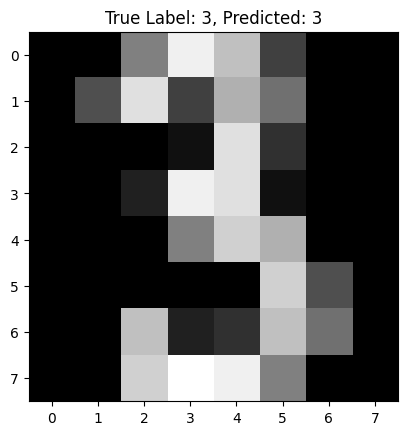

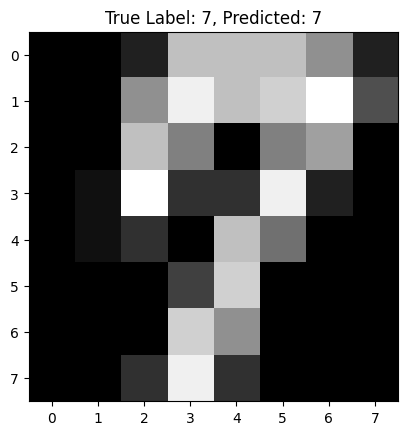

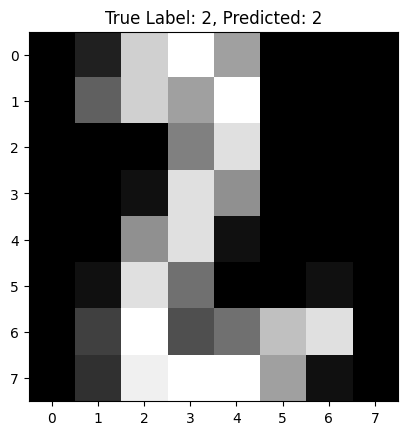

In [19]:
# Step 7: Annotate New Images
new_images = X_test[:5]  # Taking the first 5 images from the test set
H_new = np.linalg.lstsq(W_train, new_images.T, rcond=None)[0]
predicted_labels = knn.predict(H_new.T)
print("Predicted Labels for New Images:", predicted_labels)

# Visualize the Original and Predicted Labels for the First Few Test Images
for i in range(5):
    plt.imshow(X_test[i].reshape(8, 8), cmap='gray')
    plt.title(f"True Label: {y_test[i]}, Predicted: {y_pred[i]}")
    plt.show()

### Part 2: NMF-KNN (using Neural Networks) on Matrices

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim

# Example input matrix V
V = torch.rand(10, 8)
m, n = V.shape
r = 3  # Rank for NMF

# Define the NMF model
class NMFModel(nn.Module):
    def __init__(self, m, n, r):
        super(NMFModel, self).__init__()
        self.W = nn.Parameter(torch.rand(m, r))
        self.H = nn.Parameter(torch.rand(r, n))
        
    def forward(self):
        return torch.matmul(self.W, self.H)

# Instantiate the model
model = NMFModel(m, n, r)

# Define the loss function (mean squared error)
loss_fn = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    V_hat = model()  # Forward pass
    loss = loss_fn(V, V_hat)  # Compute loss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# After training
W = model.W.detach().numpy()
H = model.H.detach().numpy()

print("\nOriginal Matrix V:")
print(V.numpy())
print("\nFactorized Matrices W and H:")
print("W:")
print(W)
print("H:")
print(H)

print("\nReconstructed Matrix (W @ H):")
print(np.dot(W, H))

Epoch 0, Loss: 0.2063407450914383
Epoch 100, Loss: 0.02866494283080101
Epoch 200, Loss: 0.024310240522027016
Epoch 300, Loss: 0.024285614490509033
Epoch 400, Loss: 0.024285605177283287
Epoch 500, Loss: 0.024285605177283287
Epoch 600, Loss: 0.024285607039928436
Epoch 700, Loss: 0.024285607039928436
Epoch 800, Loss: 0.024285603314638138
Epoch 900, Loss: 0.024285605177283287

Original Matrix V:
[[0.5959504  0.3037399  0.9808321  0.29531997 0.9300612  0.14074928
  0.67551976 0.6477277 ]
 [0.9582851  0.670014   0.30073988 0.9799003  0.8047617  0.7705917
  0.9677748  0.17090303]
 [0.43052405 0.46818864 0.04455411 0.5900555  0.03588963 0.90291035
  0.02631187 0.1961931 ]
 [0.5763332  0.205306   0.51834655 0.48018885 0.98180956 0.877471
  0.8294075  0.8830975 ]
 [0.50648034 0.9379705  0.28141552 0.66820014 0.6247384  0.6437953
  0.34644115 0.28850234]
 [0.6430717  0.45606524 0.8416076  0.56265575 0.99663186 0.15507019
  0.783355   0.828574  ]
 [0.8095151  0.53236395 0.8371118  0.88352525 0.010

### Part 3: NMF-KNN (using Neural Networks) on Images

### Understanding structure of the NN -

The structure of a neural network for solving Non-negative Matrix Factorization (NMF) is typically quite simple and involves a single hidden layer. The idea is to treat the factorization problem as a specific kind of autoencoder, where the goal is to decompose a given matrix V into two matrices W and H, such that: V approx = W * H

#### 1. Neural Network Structure for NMF

- **Input Layer**:
  - The input layer represents the matrix V, where each column of V is treated as an input vector.

- **Hidden Layer**:
  - The hidden layer represents the matrix H. It has r units, where r is the rank or the number of components of the factorization. The weights of the connections from the input layer to the hidden layer correspond to the matrix W.
  - This layer is usually a fully connected layer with non-negative weights (to ensure the factorization remains non-negative).

- **Output Layer**:
  - The output layer attempts to reconstruct the input V using the product W*H. The weights connecting the hidden layer to the output layer are usually fixed or tied to the weights from the input to the hidden layer.

#### 2. Architecture Overview

- **Input Matrix** V: m*n
- **Hidden Layer** H: r*n
- **Output Layer** V' (Reconstruction): m*n

1. **Input Layer**:
   - Each input vector v_i (i.e., each column of V) has a dimension m.

2. **Hidden Layer**:
   - The hidden layer has r units (where r) is the desired rank for NMF).
   - The weights from the input to the hidden layer form the matrix W, which is (m*r).
   - The activations of the hidden layer give us the matrix H, which is r*n.

3. **Output Layer**:
   - The output layer reconstructs the input using the product W*H.
   - The output layer produces a matrix V', which is of the same dimension as the input V (i.e., m*n).

#### 3. Loss Function

- **Mean Squared Error (MSE)**:
  - The loss function typically used is the Mean Squared Error (MSE) between the original matrix V and the reconstructed matrix V'.

Loss = | V - W*H | _ F^2

- The goal is to minimize this loss, thereby ensuring that the network learns a good approximation of \( W \) and \( H \).

#### 4. Non-Negativity Constraint

- Since NMF requires the factorized matrices \( W \) and \( H \) to be non-negative, the weights are usually constrained to be non-negative. This can be enforced by:
  - **Clamping**: Applying a ReLU activation function or explicitly clamping the weights to be non-negative after each update.
  - **Regularization**: Adding a penalty to the loss function to discourage negative weights.

#### 5. Training Process

- **Backpropagation** is used to update the weights in \( W \) and \( H \).
- The network is trained iteratively until the loss converges or a set number of epochs is reached.

#### 6. Example Neural Network Structure

In PyTorch or TensorFlow, this network structure would look like:

```python
import torch
import torch.nn as nn

class NMFNet(nn.Module):
    def __init__(self, m, r, n):
        super(NMFNet, self).__init__()
        # Weight matrix W (m x r)
        self.W = nn.Parameter(torch.rand(m, r))
        # Weight matrix H (r x n)
        self.H = nn.Parameter(torch.rand(r, n))

    def forward(self):
        # Matrix multiplication of W and H to reconstruct V
        return torch.matmul(self.W, self.H)
```

#### Summary

- **Input Layer**: Represents the matrix \( V \).
- **Hidden Layer**: Represents the matrix \( H \) with \( r \) units.
- **Output Layer**: Reconstructs the input matrix using \( W \times H \).
- **Loss Function**: Mean Squared Error (MSE) to minimize reconstruction error.
- **Non-Negativity**: Enforced by clamping weights or using ReLU.

This structure is relatively simple compared to typical deep learning networks, but it’s specifically tailored to solving the NMF problem efficiently.

### Coding the actual network

In [30]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from collections import Counter

In [23]:
# Custom NMF Model
class NMFModel(nn.Module):
    def __init__(self, m, n, r):
        super(NMFModel, self).__init__()
        self.W = nn.Parameter(torch.rand(m, r))
        self.H = nn.Parameter(torch.rand(r, n))
        
    def forward(self):
        return torch.matmul(self.W, self.H)

In [32]:
def train_nmf(V, r, epochs=500, lr=0.1):
    m, n = V.shape
    model = NMFModel(m, n, r)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        V_hat = model()  # Forward pass
        loss = loss_fn(V, V_hat)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        if epoch % 100 == 0:
            print(f"\nEpoch {epoch}, Loss: {loss.item()}")

    W = model.W.detach().numpy()
    H = model.H.detach().numpy()
    return W, H

In [31]:
class CustomKNN:
    def __init__(self, n_neighbors=5, weights='uniform'):
        self.n_neighbors = n_neighbors
        self.weights = weights

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        predictions = [self._predict_single(x) for x in X_test]
        return np.array(predictions)

    def _predict_single(self, x):
        # Calculate distances between x and all training points
        distances = np.linalg.norm(self.X_train - x, axis=1)
        
        # Get the nearest neighbors
        neighbors_idx = np.argsort(distances)[:self.n_neighbors]
        neighbors_labels = self.y_train[neighbors_idx]
        neighbors_distances = distances[neighbors_idx]
        
        if self.weights == 'uniform':
            # Majority vote
            most_common = Counter(neighbors_labels).most_common(1)
            return most_common[0][0]
        elif self.weights == 'distance':
            # Weighted vote by inverse distance
            weights = 1 / (neighbors_distances + 1e-10)
            weighted_votes = Counter()
            for label, weight in zip(neighbors_labels, weights):
                weighted_votes[label] += weight
            return weighted_votes.most_common(1)[0][0]
        else:
            raise ValueError("Invalid weights parameter")

In [26]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Flatten the images and normalize
train_images = mnist_train.data.numpy().reshape(-1, 28*28).astype(np.float32) / 255.0
train_labels = mnist_train.targets.numpy()

# Standardize the features
train_images_mean = train_images.mean(axis=0)
train_images_std = train_images.std(axis=0)
train_images = (train_images - train_images_mean) / (train_images_std + 1e-10)

# Convert to tensor for PyTorch NMF
train_images_tensor = torch.tensor(train_images, dtype=torch.float32)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 9714856.89it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 288064.41it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3183720.69it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1854246.52it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [33]:
## Apply PyTorch-based NMF
n_components = 50  # Number of components
W, H = train_nmf(train_images_tensor, n_components)

# Use W as features
features_nmf = W

  0%|          | 1/500 [00:00<04:10,  1.99it/s]


Epoch 0, Loss: 159.41836547851562


 20%|██        | 101/500 [00:48<03:06,  2.14it/s]


Epoch 100, Loss: 0.9022511839866638


 40%|████      | 201/500 [01:35<02:20,  2.13it/s]


Epoch 200, Loss: 0.6385567784309387


 60%|██████    | 301/500 [02:23<01:33,  2.12it/s]


Epoch 300, Loss: 0.4918539822101593


 80%|████████  | 401/500 [03:11<00:47,  2.09it/s]


Epoch 400, Loss: 0.4396413266658783


100%|██████████| 500/500 [03:59<00:00,  2.09it/s]


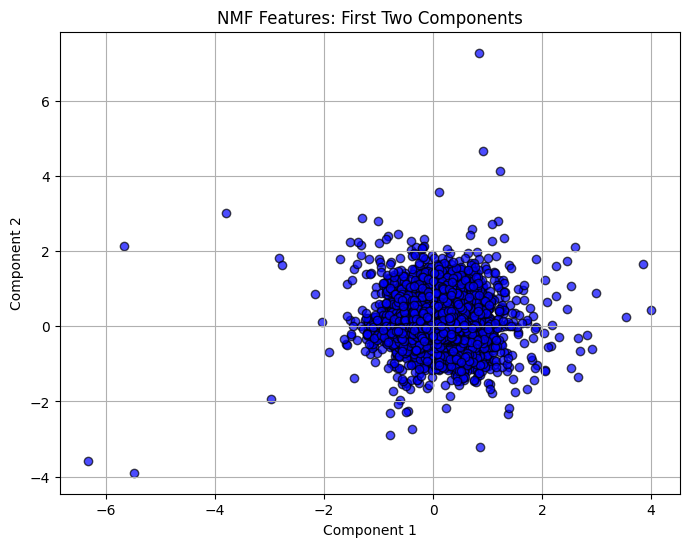

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# For visualization, we'll use only the first two components to create a scatter plot.
def plot_nmf_features(features_nmf):
    component_1 = features_nmf[:, 0]
    component_2 = features_nmf[:, 1]

    # Create a scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(component_1, component_2, c='blue', edgecolor='k', alpha=0.7)
    plt.title('NMF Features: First Two Components')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()

plot_nmf_features(features_nmf)

In [34]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_nmf, train_labels, test_size=0.2, random_state=42)

In [40]:
# Random image from training set (flattened)
X_train[5]

array([ 0.2191721 ,  0.33510074, -0.05045712, -0.18930626, -0.15643196,
       -0.3228808 , -0.17527492,  0.03335175,  0.12077621,  0.16796976,
       -0.1904945 , -0.02222328,  0.05954527,  0.14163224,  0.2396485 ,
        0.1530481 , -0.14073326, -0.25117764, -0.14187628, -0.0662716 ,
       -0.11733481,  0.25636244,  0.25727487, -0.0384912 ,  0.30424535,
        0.21752602, -0.11141969,  0.17067912,  0.12346651, -0.3726432 ,
        0.20254095,  0.23053104, -0.35286736,  0.01379207,  0.0307779 ,
        0.23179463, -0.5019057 ,  0.06093518,  0.32689375, -0.02600658,
        0.35825196,  0.02169716, -0.47401968,  0.10690509, -0.13362469,
       -0.09372956, -0.04371328, -0.16230096,  0.468473  ,  0.15996131],
      dtype=float32)

In [41]:
# Implement Custom KNN
knn = CustomKNN(n_neighbors=5, weights='distance')
knn.fit(X_train, y_train)

In [42]:
# Predict annotations (labels) for test set
y_pred = knn.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Annotation Accuracy: {accuracy*100:.2f} %")

Annotation Accuracy: 96.07 %


### What Did We Learn?

We investigated the implementation of NMF using both iterative algorithms and neural networks. Additionally, we applied NMF to both matrices and images. We also developed an NMF and KNN pipeline from scratch. Our findings show that both methods yield comparable results, with similar accuracy levels.

## Image Annotation with Corel5K

Let’s explore the application of our implementation on the Corel5K dataset, a widely used large-scale dataset for tag-based image annotation and retrieval. Corel5K comprises 4,500 images for training and 499 images for testing. Each image is manually annotated with an average of 3.4 tags from a dictionary of 260 tags. We will apply our methods to this dataset and perform image annotation as demonstrated below.

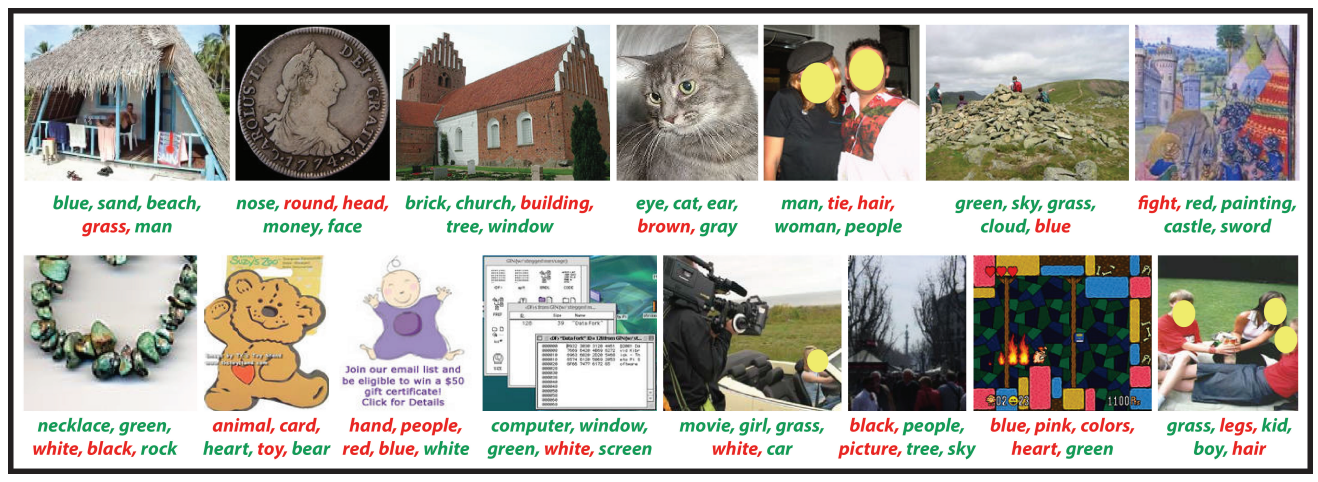

In [143]:
# Imports
import os
import json
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [144]:
# Step 1: Load the JSON file containing image names and labels
def load_json_file(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

In [145]:
file_path = '/kaggle/input/corel5k/Corel-5k/train.json'
data = load_json_file(file_path)

In [146]:
print("Sample json data: ", data['samples'][100])

Sample json data:  {'image_name': '10010.jpeg', 'image_labels': ['plane', 'runway']}


In [147]:
# Step 2: Extract image names and labels (use only the first 1000 samples for training)
image_names = []
labels = []

for item in data['samples'][:2000]:  # Use only the first 1000 samples
    image_name = item['image_name']
    image_labels = item['image_labels']
    image_names.append(image_name)
    labels.append(image_labels)

In [148]:
# Step 3: Convert labels to binary matrix using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
binary_labels = mlb.fit_transform(labels)

# Convert to Pandas DataFrame for easy viewing
df = pd.DataFrame(binary_labels, columns=mlb.classes_)
df.insert(0, 'image_name', image_names)
print("Labels converted to binary format.")

Labels converted to binary format.


### Actual Labels Used in Corel5K

In [149]:
print(df.head())  # Show the first 5 rows of the DataFrame

  image_name  albatross  anemone  antelope  antlers  arch  architecture  \
0  1000.jpeg          0        0         0        0     0             0   
1  1003.jpeg          0        0         0        0     0             0   
2  1004.jpeg          0        0         0        0     0             0   
3  1005.jpeg          0        0         0        0     0             0   
4  1006.jpeg          0        0         0        0     0             0   

   arctic  art  baby  ...  vines  vineyard  wall  water  waves  white-tailed  \
0       0    0     0  ...      0         0     0      0      0             0   
1       0    0     0  ...      0         0     0      0      0             0   
2       0    0     0  ...      0         0     0      0      0             0   
3       0    0     0  ...      0         0     0      0      0             0   
4       0    0     0  ...      0         0     0      0      0             0   

   windmills  window  woman  wood  
0          0       0      0     

In [150]:
# Step 4: Load and preprocess the Corel-5k images
def load_corel_5k(image_dir, image_names, image_size=(64, 64)):
    """
    Load and flatten images from the Corel-5k dataset.
    
    Parameters:
    image_dir (str): Directory containing Corel-5k dataset images.
    image_names (list): List of image filenames to load.
    image_size (tuple): Size to resize each image.
    
    Returns:
    X (ndarray): Flattened image data.
    """
    X = []
    original_images = []
    
    # Load the images as per the image names provided
    for img_name in tqdm(image_names, desc="Processing images"):
        img_path = os.path.join(image_dir, img_name)
        
        # Only process valid image files
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            try:
                img = Image.open(img_path).convert('L')  # Convert to grayscale
                original_images.append(Image.open(img_path).resize(image_size))  # Save for plotting later
                img = img.resize(image_size)  # Resize image
                img_array = np.array(img).flatten()  # Flatten image to 1D array
                X.append(img_array)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
        else:
            print(f"Skipped non-image file: {img_name}")

    return np.array(X), original_images

# Load images from the dataset directory (replace with your dataset directory)
image_dir = '/kaggle/input/corel5k/Corel-5k/images'
X, original_images = load_corel_5k(image_dir, image_names, image_size=(64, 64))
print(f"Loaded {X.shape[0]} images with shape {X.shape[1]}")

Processing images: 100%|██████████| 2000/2000 [00:06<00:00, 317.67it/s]

Loaded 2000 images with shape 4096


### Iterative Approach

In [151]:
# Step 5: Apply self-made NMF to reduce dimensionality of the image data
def nmf(X, n_components, max_iter=500, tol=1e-4):
    """
    Perform Non-negative Matrix Factorization (NMF) using multiplicative update rules.

    Parameters:
    X (ndarray): The data matrix with non-negative entries (n_samples x n_features).
    n_components (int): The number of latent components.
    max_iter (int): Maximum number of iterations.
    tol (float): Tolerance of the stopping condition.

    Returns:
    W (ndarray): Basis matrix (n_samples x n_components).
    H (ndarray): Coefficient matrix (n_components x n_features).
    """
    np.random.seed(42)  # For reproducibility
    n_samples, n_features = X.shape

    # Initialize W and H with non-negative random values
    W = np.abs(np.random.rand(n_samples, n_components))
    H = np.abs(np.random.rand(n_components, n_features))

    for n in range(max_iter):
        # Update H
        H_numerator = W.T @ X
        H_denominator = W.T @ W @ H + 1e-10  # Add small constant to avoid division by zero
        H *= H_numerator / H_denominator

        # Update W
        W_numerator = X @ H.T
        W_denominator = W @ H @ H.T + 1e-10  # Add small constant to avoid division by zero
        W *= W_numerator / W_denominator

        # Compute reconstruction error
        reconstruction = W @ H
        error = np.linalg.norm(X - reconstruction, ord='fro')

        if error < tol:
            print(f"Converged at iteration {n}")
            break

    return W, H

In [152]:
n_components = 200  # Number of components for NMF
W, H = nmf(X, n_components)
X_reduced = W  # Reduced representation of the images

print(f"Reduced the dimensionality of the images from {X.shape[1]} to {X_reduced.shape[1]} using self-made NMF")

Reduced the dimensionality of the images from 4096 to 200 using self-made NMF


### Feature Map (NMF using Iterative Method)

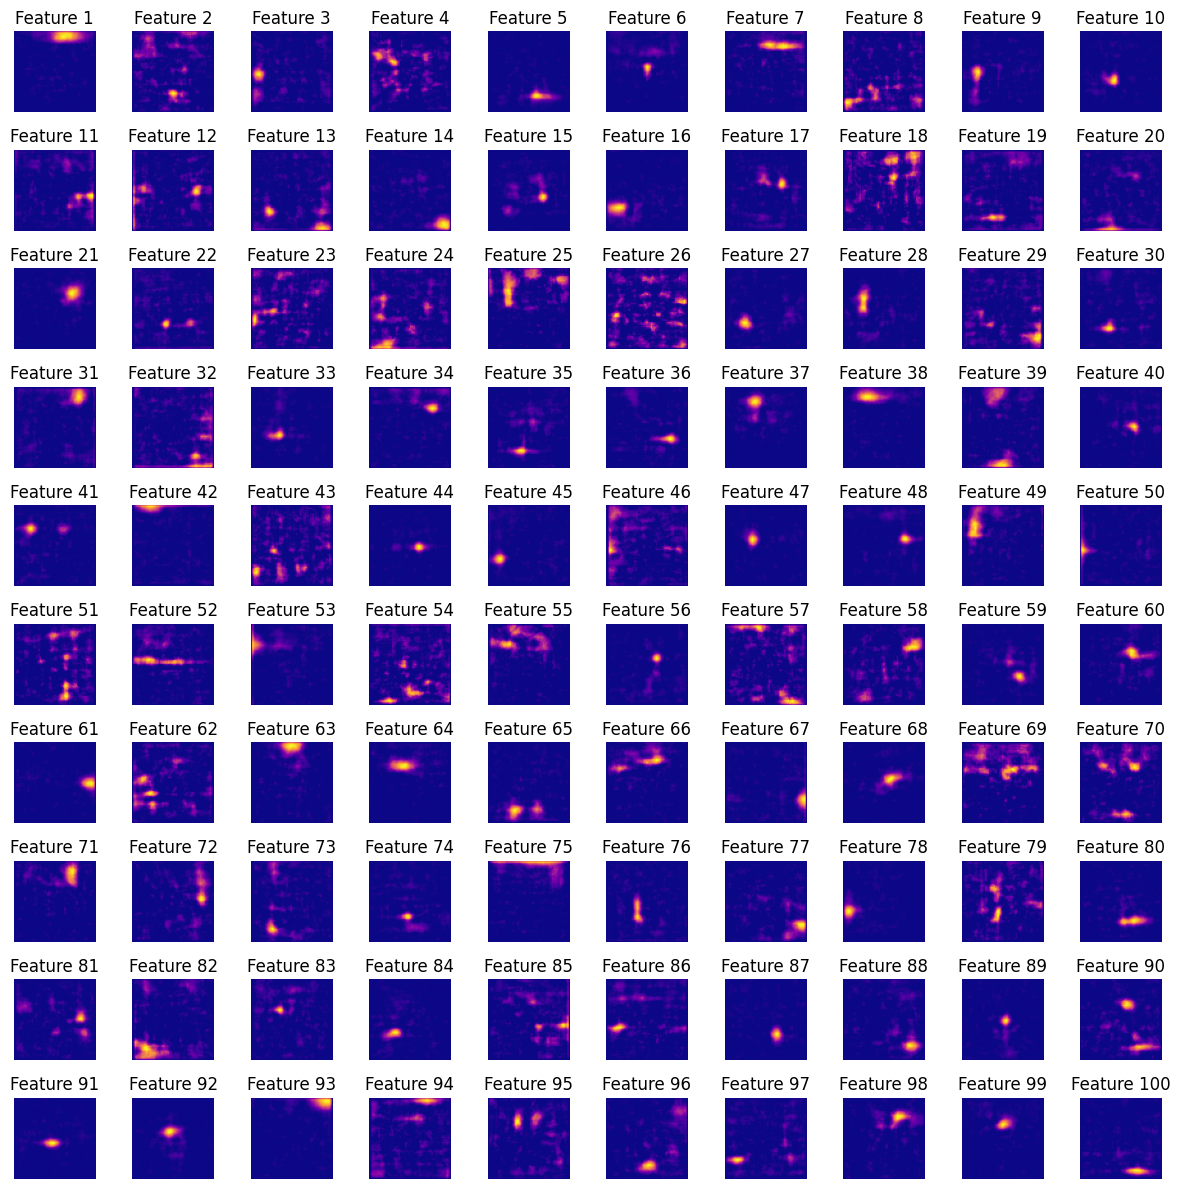

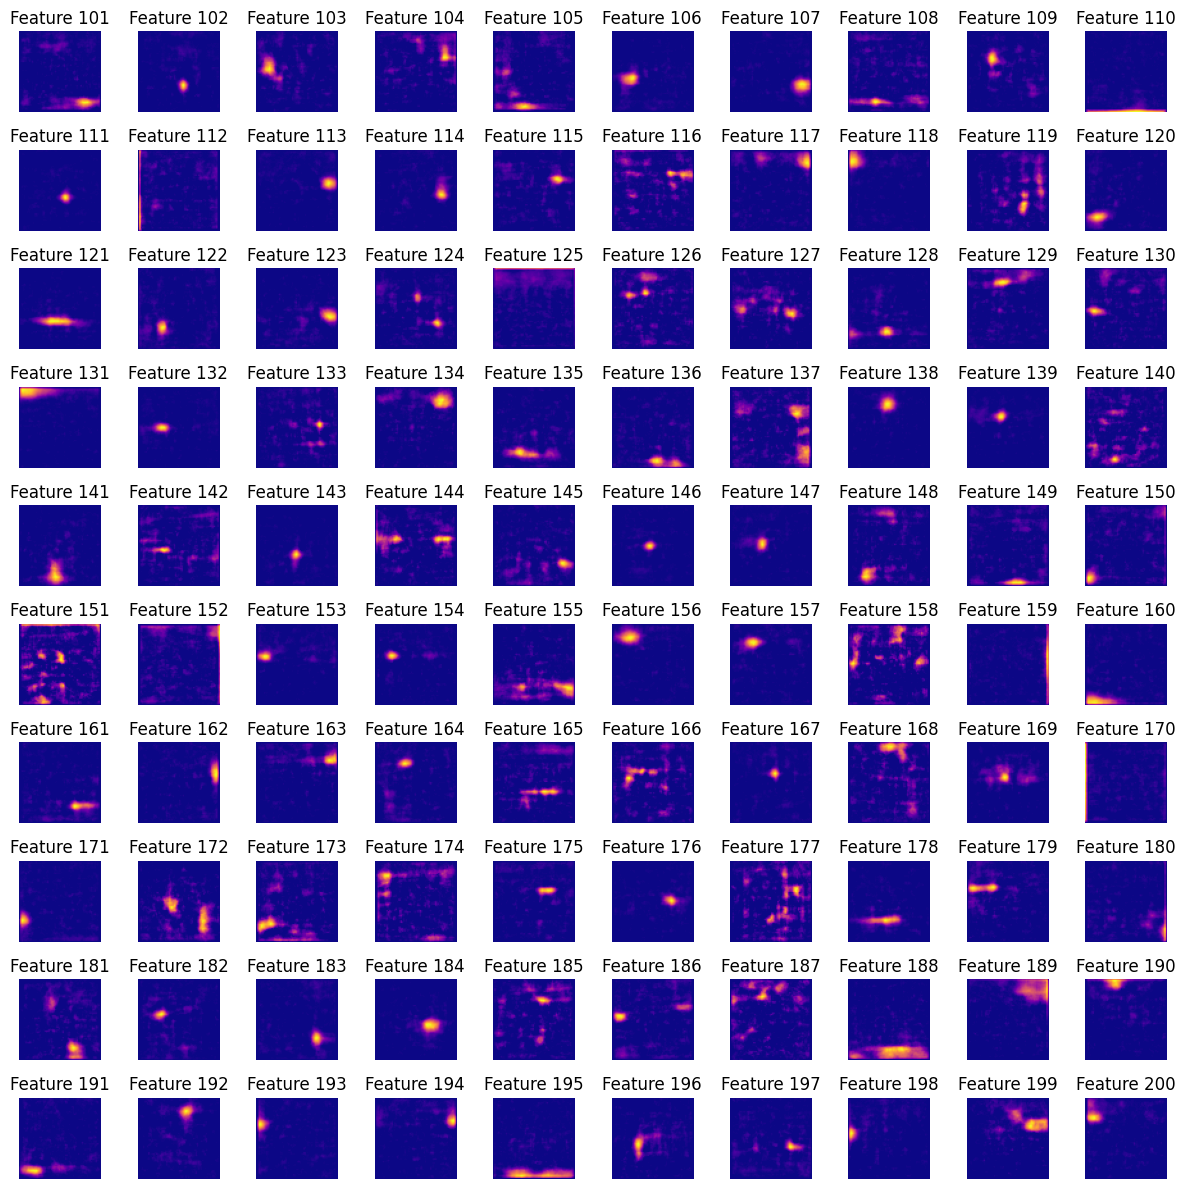

In [158]:
# Feature Subplots

n_components = 200  # 200 NMF components
n_subplots_per_fig = 100
n_figures = int(np.ceil(n_components / n_subplots_per_fig))

for fig_num in range(n_figures):
    plt.figure(figsize=(12, 12))
    start_component = fig_num * n_subplots_per_fig
    end_component = min(start_component + n_subplots_per_fig, n_components)
    for i in range(start_component, end_component):
        plt.subplot(10, 10, i - start_component + 1)
        component_image = H[i].reshape(image_size)
        plt.imshow(component_image, cmap='plasma')
        plt.title(f"Feature {i + 1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [159]:
# Step 6: Train the kNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_reduced, binary_labels)

print("kNN classifier trained on the NMF-reduced data.")

kNN classifier trained on the NMF-reduced data.


In [160]:
# Step 7: Evaluate the classifier on the training set itself (since we're using only 1000 images)
y_pred = knn.predict(X_reduced)

# Convert predictions back to label format
predicted_labels = mlb.inverse_transform(y_pred)

# Step 8: Output predictions and accuracy
accuracy = accuracy_score(binary_labels, y_pred)
print(f"Model Accuracy: {accuracy*100:.2f} %")

Model Accuracy: 3.25 %


### Actual Image Annotation Task (Iterative)

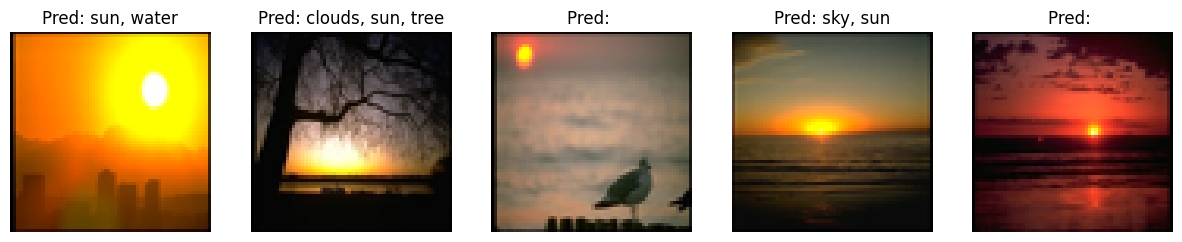

In [161]:
# Step 9: Plot some sample outputs along with their predicted labels
def plot_sample_outputs(original_images, image_names, predicted_labels, n_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(original_images[i])
        plt.title(f"Pred: {', '.join(predicted_labels[i])}")
        plt.axis('off')
    plt.show()

# Plot 5 random images and their predicted labels
plot_sample_outputs(original_images, image_names, predicted_labels, n_samples=5)

### Neural Network Based Approach

In [123]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

### Neural Network Architecture for NMF

- An autoencoder-like architecture where the encoder learns a lower-dimensional latent space (analogous to W in NMF). The decoder reconstructs the input from the latent space. We enforce non-negative constraints by using a ReLU activation function (which ensures non-negative outputs).

- Loss Function: Reconstruction loss (e.g., Mean Squared Error) is used to minimize the difference between the input data and its reconstruction.

- Training Process: We'll use the Adam optimizer to train the neural network. The loss will be monitored and plotted during training.

In [124]:
# Step 5: Neural Network-based NMF using Autoencoder Architecture
class NeuralNMF(nn.Module):
    def __init__(self, n_features, n_components):
        super(NeuralNMF, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_features, n_components),
            nn.ReLU()  # Enforces non-negative constraint
        )
        self.decoder = nn.Sequential(
            nn.Linear(n_components, n_features),
            nn.ReLU()  # Enforces non-negative reconstruction
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [163]:
def train_neural_nmf(X, n_components, epochs=100, learning_rate=0.001):
    """
    Train a neural network-based NMF using PyTorch.

    Parameters:
    X (ndarray): Input data (n_samples x n_features).
    n_components (int): Number of latent components (similar to NMF).
    epochs (int): Number of training epochs.
    learning_rate (float): Learning rate for optimizer.

    Returns:
    W (ndarray): Learned latent components.
    H (ndarray): Learned basis components (reconstructed input).
    model (nn.Module): Trained model.
    losses (list): Training losses over time.
    """
    n_samples, n_features = X.shape
    model = NeuralNMF(n_features, n_components)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    # Convert X to tensor
    X_tensor = torch.FloatTensor(X)

    losses = []

    for epoch in range(epochs):
        model.train()

        optimizer.zero_grad()
        encoded, decoded = model(X_tensor)
        loss = loss_fn(decoded, X_tensor)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if (epoch + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

    W = encoded.detach().numpy()
    H = decoded.detach().numpy()

    return W, H, model, losses

In [126]:
# Step 5b: Plot training loss
def plot_training_loss(losses):
    plt.figure(figsize=(8, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Time')
    plt.legend()
    plt.show()

In [162]:
# Load and preprocess data
n_components = 200
epochs = 2000
learning_rate = 0.001

# Normalize X to [0, 1] range for better convergence
X_normalized = X / X.max()

### Training Loss Plot

Epoch [100/2000], Loss: 0.0655
Epoch [200/2000], Loss: 0.0511
Epoch [300/2000], Loss: 0.0416
Epoch [400/2000], Loss: 0.0359
Epoch [500/2000], Loss: 0.0324
Epoch [600/2000], Loss: 0.0299
Epoch [700/2000], Loss: 0.0282
Epoch [800/2000], Loss: 0.0274
Epoch [900/2000], Loss: 0.0262
Epoch [1000/2000], Loss: 0.0256
Epoch [1100/2000], Loss: 0.0250
Epoch [1200/2000], Loss: 0.0244
Epoch [1300/2000], Loss: 0.0241
Epoch [1400/2000], Loss: 0.0238
Epoch [1500/2000], Loss: 0.0236
Epoch [1600/2000], Loss: 0.0235
Epoch [1700/2000], Loss: 0.0235
Epoch [1800/2000], Loss: 0.0237
Epoch [1900/2000], Loss: 0.0233
Epoch [2000/2000], Loss: 0.0232


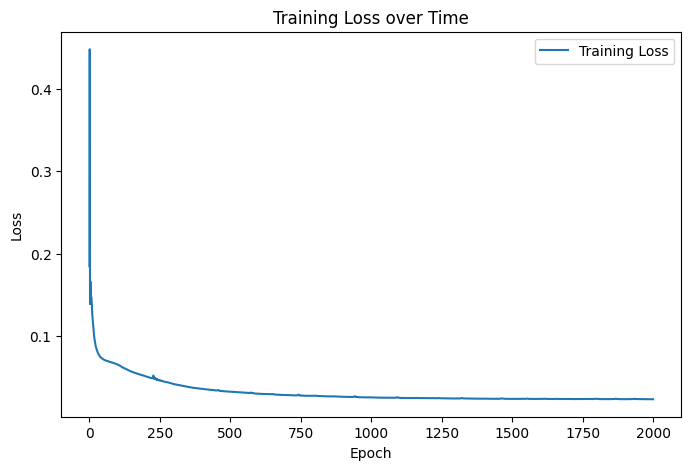

In [164]:
# Step 6: Train the neural NMF
W, H, model, losses = train_neural_nmf(X_normalized, n_components, epochs=epochs, learning_rate=learning_rate)

# Plot the training loss
plot_training_loss(losses)

### Feature Map (NMF using Neural Networks)

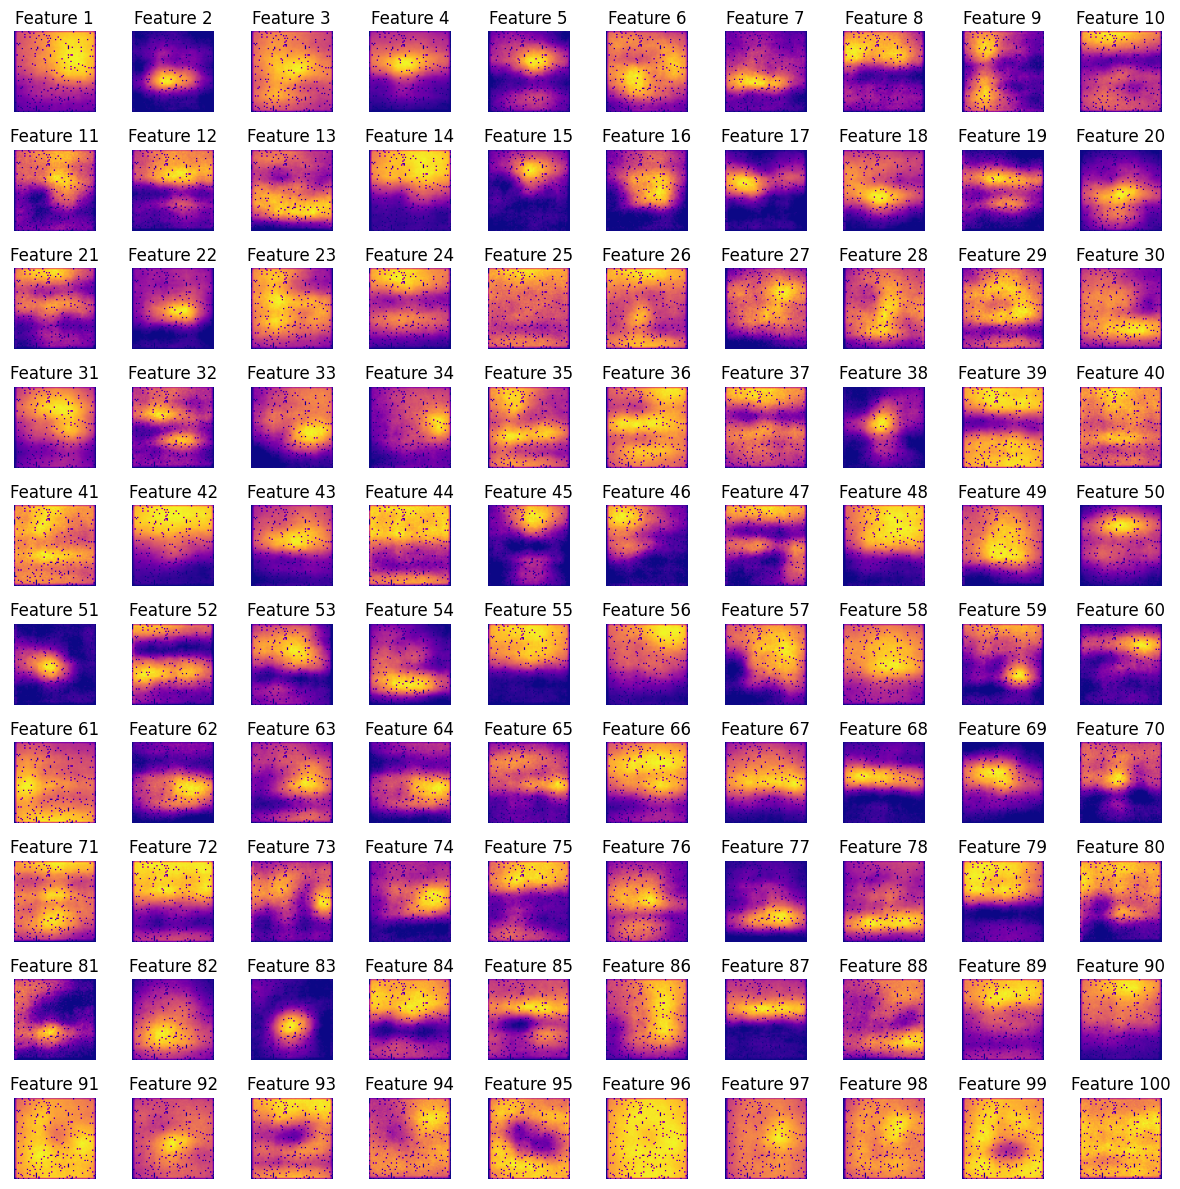

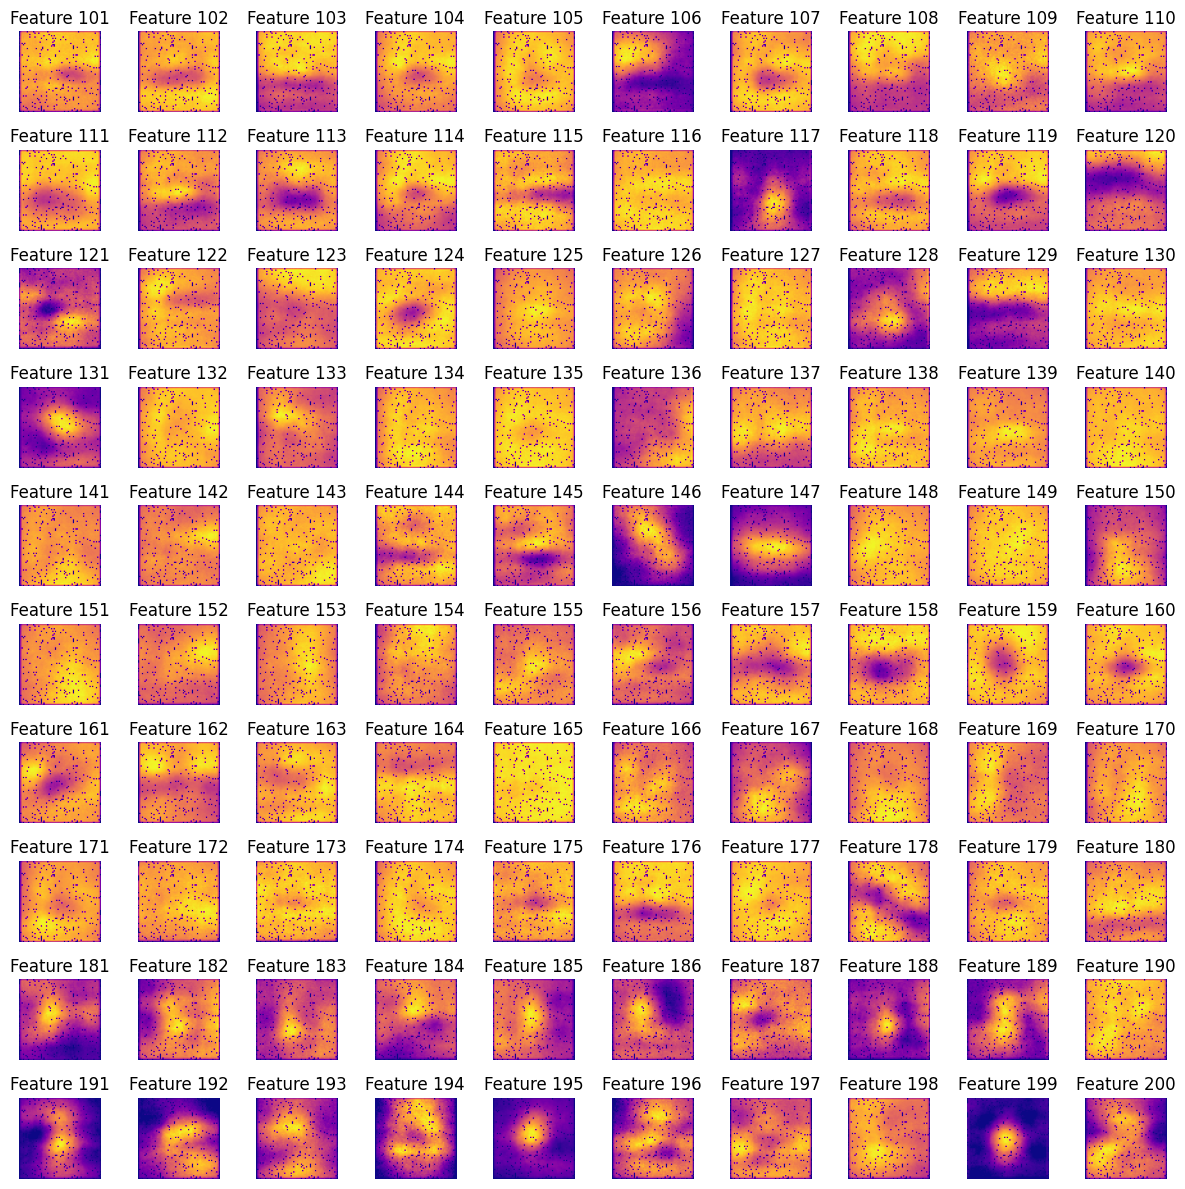

In [165]:
# Feature Subplots

n_components = 200  # 200 NMF components
n_subplots_per_fig = 100
n_figures = int(np.ceil(n_components / n_subplots_per_fig))

for fig_num in range(n_figures):
    plt.figure(figsize=(12, 12))
    start_component = fig_num * n_subplots_per_fig
    end_component = min(start_component + n_subplots_per_fig, n_components)
    for i in range(start_component, end_component):
        plt.subplot(10, 10, i - start_component + 1)
        component_image = H[i].reshape(image_size)
        plt.imshow(component_image, cmap='plasma')
        plt.title(f"Feature {i + 1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [166]:
# Step 7: Train the kNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(W, binary_labels)

print("kNN classifier trained on the neural NMF-reduced data.")

kNN classifier trained on the neural NMF-reduced data.


In [167]:
# Step 8: Evaluate the classifier on the training set itself
y_pred = knn.predict(W)
predicted_labels = mlb.inverse_transform(y_pred)

accuracy = accuracy_score(binary_labels, y_pred)
print(f"Model Accuracy: {accuracy*100:.2f} %")

Model Accuracy: 4.55 %


### Actual Image Annotation Task (using NN)

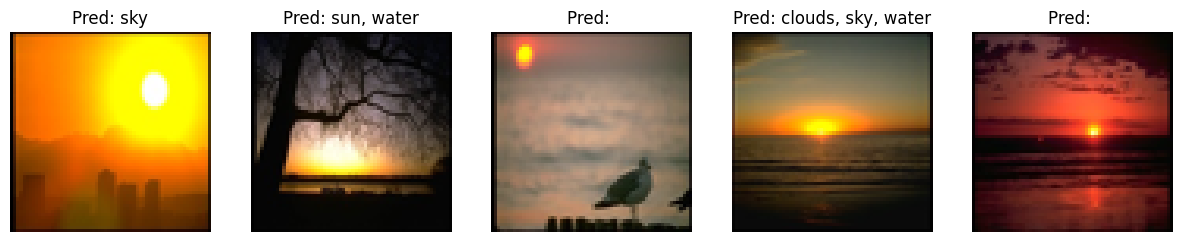

In [168]:
# Step 9: Plot some sample outputs along with their predicted labels
plot_sample_outputs(original_images, image_names, predicted_labels, n_samples=5)

## Conclusion

In conclusion, we successfully implemented image annotation using NMF-KNN, leveraging both the iterative and neural network-based approaches for Non-negative Matrix Factorization (NMF), both of which were self-developed. This work underscores the significant role that NMF can play in the field of image annotation, as it effectively reformulates the annotation challenge into an NMF problem and solves it efficiently. By doing so, we demonstrated the potential of NMF in improving the performance and accuracy of image annotation tasks, highlighting its value as a versatile tool in machine learning and computer vision applications. This approach offers valuable insights and proves particularly useful in scenarios where traditional annotation methods may fall short. Through our implementation, we have illustrated the practical benefits of using NMF for image annotation, opening the door for further research and development in this area.

### Thank You!